# 机器学习报告二：回归模型
- 姓名：李欣
- 学号：2011165
- 专业：计算机科学与技术

### 实验要求
题目：回归模型

* 回归是监督学习的一个重要问题，回归用于预测输入变量和输出变量之间的关系，特别是当输入变量的值发生变化时，输出变量的值也随之发生变化。
* 回归模型是一种表示从输入变量到输出变量之间映射的函数
* 对连续值的预测
* 可以用合适的曲线揭示样本点随着自变量的变化关系
实验条件：给定winequality-white.csv数据集

实验要求：
1. 基本要求：
构建线性回归模型，学习使用批量梯度下降和随机梯度下降进行优化，并进行一定的分析。
2. 中级要求：
探究回归模型在机器学习和统计学上的差异。
3. 提高要求：
编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法均可）。

### 导入需要的包

In [2]:
# 导入pandas
import pandas as pd
# 导入numpy
import numpy as np

### 导入数据集

In [3]:
# 使用pd.read_csv函数读入csv文件
data = pd.read_csv("winequality-white.csv")
# 显示date文件的前五行和后五行
# data.head(5)
# data.tail(5)
test_data=data
test_data1=data
print("原数据集大小:",test_data.shape[0])
test_data=test_data.drop_duplicates() # 包含重复值
print("去重后保留重复值数据集大小:",test_data.shape[0])
test_data1=test_data1.drop_duplicates(keep=False) # 包含重复值
print("去重后不保留重复值数据集大小:",test_data1.shape[0])

原数据集大小: 4898
去重后保留重复值数据集大小: 3961
去重后不保留重复值数据集大小: 3189


发现原数据集中有不少重复的数据（行），对回归系数与mse损失函数可能会产生影响。在本次实验中我们没有考虑去重问题，在后期会进行可能的改进。

### 数据预处理

In [4]:
# 数据预处理的几种方法
# np.mean(x, 0)计算每一列的均值
# np.max(x, 0)计算每一列的最大值
# np.min(x, 0)计算每一列的最小值

def Zero_c_N(x):
    return (x - np.mean(x, 0)) / (np.max(x, 0) - np.min(x, 0))

def Normalization(x):
    x = (x - np.min(x, 0)) / (np.max(x, 0) - np.min(x, 0))
    return x

def Standardization(x):
    return (x - np.mean(x, 0)) / np.std(x, 0)

# 提取特征和标签
# 所有行的0到最后第二列的数据，为特征
X = data.iloc[:, 0:-1]  #
X = Standardization(X)
#所有行的最后一列的数据为标签
Y = data.iloc[:, -1]

经过实验测试，使用Standardization的效果最好。

(array([  83.,  931., 1440., 1402.,  623.,  235.,  134.,   26.,   20.,
           4.]),
 array([-2.36470935, -1.61107823, -0.85744711, -0.10381598,  0.64981514,
         1.40344626,  2.15707739,  2.91070851,  3.66433963,  4.41797076,
         5.17160188]),
 <BarContainer object of 10 artists>)

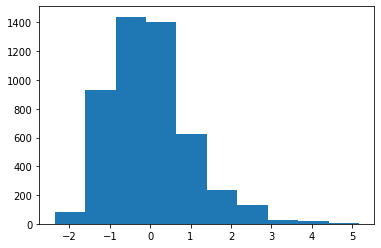

In [5]:
# 可视化中心化后的sulphates特征
import matplotlib.pyplot as plt
plt.hist(X["sulphates"])
plt.show()

In [6]:
# 这里注意一个小trick：回归系数会比特征x多一维，为了向量相乘方便，可以在训练集X左侧添加全为1的一列
# concat函数用于拼接
# shape[0]获取行数
# anxis=1 按列拼接
# pd.DataFrame(np.ones(X.shape[0]), columns=['x0']) 左边是一列名为x0且元素全为1的列
# X 右边是X
data0 = pd.concat([pd.DataFrame(np.ones(X.shape[0]), columns=['x0']), X], axis=1)
data0

,x0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152
1,1.0,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276
2,1.0,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667
3,1.0,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
4,1.0,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,1.0,-0.776015,-0.677101,-0.365197,-0.944765,-0.310008,-0.664970,-1.091000,-0.965483,0.541334,0.088973,0.557282
4894,1.0,-0.301959,0.414339,0.213280,0.317179,0.056196,1.275590,0.697499,0.291789,-0.253446,-0.261553,-0.743008
4895,1.0,-0.420473,-0.379435,-1.191592,-1.023637,-0.218457,-0.312141,-0.643875,-0.497350,-1.313153,-0.261553,-0.905544
4896,1.0,-1.605613,0.116674,-0.282557,-1.043355,-1.088192,-0.900190,-0.667408,-1.784717,1.004955,-0.962605,1.857572


### 一、基本要求

具体要求：

将数据集winequality-white.csv按照4:1划分为训练集和测试集。

1. 构造线性回归模型，并采用批量梯度下降和随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。

2. 对于批量梯度下降和随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。
 
特别需要注意：

* 划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。

* 需要对数据集进行一定的预处理

#### (一)步骤一：将数据集按照4:1划分为训练集和测试集(应选用方法2：按照标签重新划分数据集)

##### 1、不能满足该实验要求，但有点道理的划分数据集，在不是分类的情况下可能可以选取的划分方法

随机排列函数np.random.permutation将索引随机打乱

In [7]:
# 将索引随机打乱
row_indices=np.random.permutation(data0.shape[0])
# 查看打乱后的索引
row_indices
# # 将拼接过后的特征矩阵/分类结果 按照4:1的比例划分，训练集的个数
num=int((row_indices.shape[0])*0.8)

array([1818,  133,  288, ..., 3511,  865, 1032])

创建训练集

In [8]:
# 创建训练集
# row_indices[0:num]
x_train=data0.iloc[row_indices[0:num],:]
y_train=Y.iloc[row_indices[0:num]]
# 训练集的个数
print("训练集的大小为:",x_train.shape[0])

训练集的大小为: 3918


创建测试集

In [9]:
# 创建测试集
# row_indices[num:]
x_test=data0.iloc[row_indices[num:],:]
y_test=Y.iloc[row_indices[num:]]
# 测试集的个数
print("测试集的大小为:",x_test.shape[0])

测试集的大小为: 980


*注意！！！*
如上创建测试集似乎由一些问题，和同学交流过后我认识到，quality为分类结果label，因为训练结果为几个label(3-9)，极端情况下，存在某一label都被训练到或某一label完全没有训练到。

显然，训练和测试结果很有可能出现较大的偏差。故，应将每一类别的数据划分训练集和测试集

此外，应该看一看原数据集中是否有相同的行

##### 2、按照分类结果，即标签重新划分数据集

In [10]:
# 上述方法不行！重新切分数据
data0=pd.concat([X,Y],axis=1)
data0.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.172097,-0.081770,0.213280,2.821349,-0.035355,0.569932,0.744565,2.331512,-1.246921,-0.349184,-1.393152,6
1,-0.657501,0.215896,0.048001,-0.944765,0.147747,-1.253019,-0.149685,-0.009154,0.740029,0.001342,-0.824276,6
2,1.475751,0.017452,0.543838,0.100282,0.193523,-0.312141,-0.973336,0.358665,0.475102,-0.436816,-0.336667,6
3,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,6
4,0.409125,-0.478657,-0.117278,0.415768,0.559727,0.687541,1.121091,0.525855,0.011480,-0.787342,-0.499203,6


分层随机选取训练样本

In [27]:
#分层 随机 选取训练样本
def sample_split(data, train_ratio=0.8, label='quality', seed=None):
    xy_test=None
    # 根据分类标签分组
    xy_train = data.groupby(label).apply(lambda x: x.sample(frac=train_ratio, random_state=seed))
    
    # 将xy_train每行索引存入列表，为了找到在data中对应的行，删除得到test数据集
    list_index=[]
    for i in range(0,xy_train.shape[0]):
        list_index.append((xy_train.iloc[i].name)[1])
    xy_test=np.delete(data.values,list_index,axis=0)
    
    # 将训练集打乱顺序
    xy_train = xy_train.sample(frac=1, random_state=seed)
    xy_train.reset_index(drop=True, inplace=True)
    
    return xy_train, xy_test

# 训练集和测试集
type(data0)
train, test = sample_split(data0)

pandas.core.frame.DataFrame

In [28]:
print("数据集大小:",data0.shape[0])
print("训练集大小(80%):",train.shape[0])
print("测试集大小(20%):",test.shape[0])
test=pd.DataFrame(test)

数据集大小: 4898
训练集大小(80%): 3918
测试集大小(20%): 980


训练集测试与标签分离

In [13]:
# 提取特征和标签
x_temp= train.iloc[:,:-1]
y=train.iloc[:, -1]

# 这里注意一个小trick：回归系数会比特征x多一维，为了向量相乘方便，可以在训练集X左侧添加全为1的一列
x_final = pd.concat([pd.DataFrame(np.ones(x_temp.shape[0]), columns=['x0']), x_temp], axis=1)
size, feature_num = x_final.shape

# 便于后续计算，将特征矩阵和分类结果都由dataframe转换为二维ndarray：
x_train= x_final.values
y_train = y.values.reshape(y.shape[0],1)

测试集特征与分类标签分离

In [14]:
x = test.iloc[:,:-1]
y = test.iloc[:, -1]
x = pd.concat([pd.DataFrame(np.ones(x.shape[0]), columns=['x0']), x], axis=1)
test_x = x.values
test_y = y.values.reshape(y.shape[0],1)

至此划分好了训练集和测试集

#### (二)步骤二：线性回归模型

1. 定义损失函数mse：

In [15]:
def compute_mse(x,y,theta):
    return np.mean((x@theta-y)**2)

2. 批量梯度下降：

In [16]:
def fit_gd(x, y, theta, learning_ratio=0.01, max_iter=10000, change_ratio=1e-4, n_unchange=5):
    n_iter = 0
    no_change = 0
    mses = []
    random_mse=compute_mse(x,y,theta)
    mses.append(random_mse)
    # 停止条件：
    # 1.到达最大迭代次数
    # 2.边化率太小
    while n_iter < max_iter:
        n_iter += 1
        theta = learning_ratio/size * x.T@(y - x@theta) + theta 
        mse_temp = compute_mse(x,y,theta)
        if abs(mse_temp - mses[-1]) < change_ratio:
            no_change += 1
            if no_change >= n_unchange:
                break
        else:
            no_change = 0
        mses.append(mse_temp)
    return theta, mses

In [17]:
# 初始化回归系数
W_init = np.random.rand(feature_num, 1)
W_init.reshape(feature_num)

array([0.30809531, 0.36605552, 0.13846   , 0.18538677, 0.99626649,
       0.13420059, 0.23141642, 0.25913349, 0.98135508, 0.87390355,
       0.66953199, 0.27299143])

In [18]:
w_gd, mses_gd = fit_gd(x_train,y_train,W_init, learning_ratio=0.01, max_iter=1000, change_ratio=1e-19, n_unchange=5)
# mses_gd
print("批量梯度下降训练集mse：",mses_gd[-1])

批量梯度下降训练集mse： 0.5686416292571671


3. 随机梯度下降

In [19]:
def fit_sgd(x, y, theta, learning_ratio=0.01, max_iter=10000, change_ratio=1e-6, n_unchange=5):
    n_iter = 0
    no_change = 0
    mses = []
    random_mse=compute_mse(x,y,theta)
    mses.append(random_mse)
    while n_iter < max_iter:
        n_iter += 1
        i = np.random.randint(size)
        tmp = (y[i] - x[i]@theta)
        theta = learning_ratio * x[i].reshape(feature_num,1)*tmp + theta
        mse_temp = compute_mse(x,y,theta)
        if abs(mse_temp - mses[-1]) < change_ratio:
            no_change += 1
            if no_change >= n_unchange:
                break
        else:
            no_change = 0
        mses.append(mse_temp)
    return theta, mses

In [20]:
w_sgd, mses_sgd = fit_sgd(x_train,y_train,W_init, learning_ratio=0.01, max_iter=1000, change_ratio=1e-4, n_unchange=5)
print("随机梯度下降训练集mse：",mses_sgd[-1])

随机梯度下降训练集mse： 0.5814792570672931




#### (三)步骤三：训练集和测试集结果

In [21]:
print("批量梯度下降训练集mse：",mses_gd[-1])
print("批量梯度下降测试集mse：",compute_mse(test_x,test_y,w_gd))

print("随机梯度下降训练集mse：",mses_sgd[-1])
print("随机梯度下降测试集mse：",compute_mse(test_x,test_y,w_sgd))

批量梯度下降训练集mse： 0.5686416292571671
批量梯度下降测试集mse： 0.5682573628607406
随机梯度下降训练集mse： 0.5814792570672931
随机梯度下降测试集mse： 0.5870369253924073


#### (四)步骤四：绘制mse收敛曲线

Text(0.5, 0, 'n_iters')

Text(0, 0.5, 'mse')

Text(0.5, 1.0, 'mse with different n_iters')

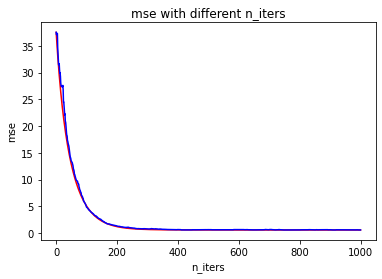

In [22]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.plot(np.arange(len(mses_gd)), mses_gd, 'r')
axes.plot(np.arange(len(mses_sgd)), mses_sgd, 'b')
axes.set_xlabel('n_iters')
axes.set_ylabel('mse')
axes.set_title('mse with different n_iters')

#### (五)步骤五

In [23]:
# learning_ratio_list=[0.001,0.005,0.01,0.05,0.1,0.3,0.5]
learning_ratio_list=(0.001,0.002,0.004,0.005,0.008,0.01,0.05,0.1,0.11)
gd_mses=[]
sgd_mses=[]
# gd_mses.append(compute_mse(x_train,y_train,W_init))    
# sgd_mses.append(compute_mse(x_train,y_train,W_init))

for l_r in learning_ratio_list:
    w_gd,mses = fit_gd(x_train,y_train,theta=W_init, learning_ratio=l_r)
    w_sgd,smses = fit_sgd(x_train,y_train,theta=W_init,learning_ratio=l_r)
    gd_mses.append(compute_mse(x_train,y_train,w_gd))    
    sgd_mses.append(compute_mse(x_train,y_train,w_sgd))
# gd_mses
sgd_mses

[0.5711885067465754,
 0.5730638534401142,
 0.6009722832399678,
 0.5858428693245122,
 0.5854269632262313,
 0.6116584098337158,
 0.8188827629569787,
 2.1526951288881047,
 1.4369978574664528]

Text(0.5, 0, 'n_iters')

Text(0, 0.5, 'mse')

Text(0.5, 1.0, 'mse with different n_iters')

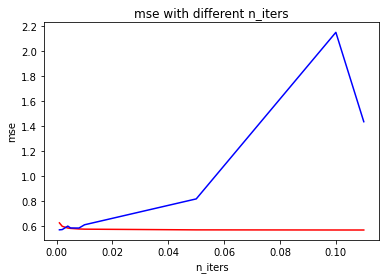

In [24]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.plot(learning_ratio_list, gd_mses, 'r')
axes.plot(learning_ratio_list, sgd_mses, 'b')
axes.set_xlabel('n_iters')
axes.set_ylabel('mse')
axes.set_title('mse with different n_iters')

实验要求我们对于批量梯度下降和随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。我选取了(0.001,0.002,0.004,0.005,0.008,0.01,0.05,0.1,0.11)，若学习率太高的话，如上图所示，红色的是随机梯度下降，绿色的是批量梯度下降，当学习率到达一定数值时，随机梯度下降的mse会出现非常明显的抖动。

故随机梯度下降更适合低学习率，从图中看，批量梯度下降高低学习率都适用，但在实际应用中，不能一味使用批量梯度下降，当数据量很大时，批量梯度下降的时间开销会非常大。


### 二、中级要求
探究回归模型在机器学习和统计学上的差异。

* 回归模型在机器学习领域和统计学领域中都十分常用，而且使用方法也相似，但其实际的含义具有本质的区别。我们希望同学们从回归模型的角度更加充分地理解机器学习和统计学的区别。

本次实验的线性回归是一种统计学方法，我们使用机器学习来构建模型。

在构建机器学习的模型过程中，我们需要将数据集分为训练集和测试集两个数据子集，并对模型进行一定的“训练”。此外，在我们使用测试集对模型测试前，我们并不知道这个模型的性能。


我认为：

* 机器学习的重点在于预测，即获得基于测试数据集的最优输出(如使用各种损失函数进行衡量)，从而模型性能达到最优。

* 统计模型的重点在于刻画已有数据与结果变量之间的关系，而不是对未来的数据进行预测。该过程被称为统计推断过程，而非预测过程。

衡量标准：
* 机器学习:测试集的预测准确度
* 统计模型:显著性检验，置信区间等

部分参考：[读懂统计学与机器学习的本质区别](https://blog.csdn.net/eNohtZvQiJxo00aTz3y8/article/details/89879697)

### 三、高级要求
编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法均可）。

+ 岭回归：
 实质上是一种改良的最小二乘估计法，通过放弃最小二乘法的无偏性，以损失部分信息、降低精度为代价获得回归系数更为符合实际、更可靠的回归方法，对病态数据的拟合要强于最小二乘法。

In [24]:
## 平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法均可）
# 解析法
def weights(x,y,lam=0.2):
    x_mat= np.mat(x)
    y_mat =np.mat(y)
    xtx=x_mat.T*x_mat
    rxtx = xtx+lam*np.eye(x_mat.shape[1])
    if np.linalg.det(rxtx) == 0.0:
        print("This matrix cannot do inverse, plz change lambda.")
        return 

    theta = rxtx.I*x_mat.T*y_mat
    return theta

In [25]:
w_t = weights(x_train,y_train)
# !!! 岭系数
w=np.asarray(w_t)
print("平均训练mse:")
print(compute_mse(x_train,y_train,w))
print("平均测试mse:")
print(compute_mse(test_x,test_y,w))

平均训练mse:
0.5678390774407152
平均测试mse:
0.5462387164993198


In [27]:
lams = [0,0.01,0.02,0.04,0.08,0.10,0.12,0.16,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55]

# lams
train_mses =[]
test_mses = []
for lam in lams:
    w_t = weights(x_train,y_train,lam)
    w=np.asarray(w_t)
    train_mses.append(compute_mse(x_train,y_train,w))
    test_mses.append(compute_mse(test_x,test_y,w))

test_mses

[0.5462547424452671,
 0.5462539344198891,
 0.5462531271034841,
 0.5462515145970889,
 0.5462482980864349,
 0.546246694080167,
 0.5462450929052668,
 0.5462418990455624,
 0.5462387164993198,
 0.5462347542139077,
 0.5462308095777458,
 0.5462268825753205,
 0.5462229731911606,
 0.5462190814098385,
 0.5462152072159692,
 0.5462113505942108]

在本实验中，改变lam值，mse并没有很大的改变，我们可以对lam做进一步的探究。